In [1]:
import tensorflow as tf
import numpy as np
import sys
import os
import numpy as np
import cv2
import glob
from PIL import Image
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
import time
from tensorflow import keras
from tensorflow.keras import layers
import os

from keras.layers import UpSampling2D, Conv2D

Using TensorFlow backend.


In [2]:
!wget http://abcom.com/tf/tf-book.zip


--2020-07-16 10:15:25--  http://abcom.com/tf/tf-book.zip
Resolving abcom.com (abcom.com)... 104.24.103.18, 104.24.102.18, 172.67.220.7, ...
Connecting to abcom.com (abcom.com)|104.24.103.18|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 643661413 (614M) [application/zip]
Saving to: ‘tf-book.zip’

tf-book.zip         100%[===================>] 613.84M  40.1MB/s    in 16s     

2020-07-16 10:15:41 (39.4 MB/s) - ‘tf-book.zip’ saved [643661413/643661413]



In [3]:
!unzip tf-book.zip

Streaming output truncated to the last 5000 lines.
  inflating: __MACOSX/tf-book/chapter13/anime/data/._8580.png  
  inflating: tf-book/chapter13/anime/data/9846.png  
  inflating: __MACOSX/tf-book/chapter13/anime/data/._9846.png  
  inflating: tf-book/chapter13/anime/data/18808.png  
  inflating: __MACOSX/tf-book/chapter13/anime/data/._18808.png  
  inflating: tf-book/chapter13/anime/data/11192.png  
  inflating: __MACOSX/tf-book/chapter13/anime/data/._11192.png  
  inflating: tf-book/chapter13/anime/data/2913.png  
  inflating: __MACOSX/tf-book/chapter13/anime/data/._2913.png  
  inflating: tf-book/chapter13/anime/data/21051.png  
  inflating: __MACOSX/tf-book/chapter13/anime/data/._21051.png  
  inflating: tf-book/chapter13/anime/data/16825.png  
  inflating: __MACOSX/tf-book/chapter13/anime/data/._16825.png  
  inflating: tf-book/chapter13/anime/data/20429.png  
  inflating: __MACOSX/tf-book/chapter13/anime/data/._20429.png  
  inflating: tf-book/chapter13/anime/data/17285.png  
  

In [4]:
def load_dataset(batch_size, img_shape, data_dir=None):
    #creating a tuple of size(30000,64,64,3)
    sample_dim = (batch_size,) + img_shape   
    #creating an unitialized array of shape (30000,64,64,3)  
    sample = np.empty(sample_dim, dtype=np.float32) 
    #now,extracting all the images from our file
    all_data_dirlist = list(glob.glob(data_dir)) 
    
    #randomly selects the image file from our data list
    sample_imgs_paths = np.random.choice(all_data_dirlist,batch_size) 
  
    for index,img_filename in enumerate(sample_imgs_paths):
        #opening the image
        image = Image.open(img_filename) 
        #resizing the image
        image = image.resize(img_shape[:-1]) 
        #converting our input into an array
        image = np.asarray(image) 
        # normalizing data
        image = (image/127.5) -1 
        #assigning the preprocessed image to our sample
        sample[index,...] = image  
    print("Data loaded")
    return sample



In [5]:
x_train=load_dataset(30000,(64,64,3), "/content/tf-book/chapter13/anime/data/*.png")
BUFFER_SIZE = 30000

BATCH_SIZE = 256
train_dataset = tf.data.Dataset.from_tensor_slices(x_train).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

Data loaded


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(30000, 64, 64, 3)

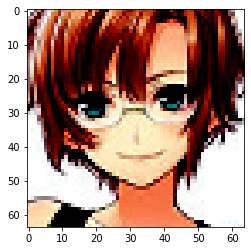

In [6]:
plt.imshow(x_train[5])
x_train.shape


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  """
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow wi

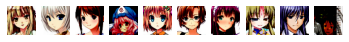

In [7]:
n = 10
f = plt.figure()
for i in range(n):
    f.add_subplot(1, n, i + 1)
    plt.subplot(1, n, i+1 ).axis("off")
    plt.imshow(x_train[i])
plt.show()

In [8]:
def make_generator_model():
    model = tf.keras.Sequential()
    model.add(tf.keras.layers.Dense(64*4*4, use_bias=False, input_shape=(100,)))
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.LeakyReLU())
      
    model.add(tf.keras.layers.Reshape((4,4,64)))

    model.add(tf.keras.layers.Conv2DTranspose(256, (5, 5), strides=(1, 1), padding='same', use_bias=False))
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.LeakyReLU())

    model.add(tf.keras.layers.Conv2DTranspose(128, (5, 5), strides=(2, 2), padding='same', use_bias=False))
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.LeakyReLU())

    model.add(tf.keras.layers.Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same', use_bias=False))
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.LeakyReLU())

    model.add(tf.keras.layers.Conv2DTranspose(32, (5, 5), strides=(2, 2), padding='same', use_bias=False))
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.LeakyReLU())

   

    model.add(tf.keras.layers.Conv2DTranspose(3, (5, 5), strides=(2, 2), padding='same', use_bias=False, activation='tanh'))

    model.summary()

    
   
    
    return model


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 1024)              102400    
_________________________________________________________________
batch_normalization (BatchNo (None, 1024)              4096      
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 1024)              0         
_________________________________________________________________
reshape (Reshape)            (None, 4, 4, 64)          0         
_________________________________________________________________
conv2d_transpose (Conv2DTran (None, 4, 4, 256)         409600    
_________________________________________________________________
batch_normalization_1 (Batch (None, 4, 4, 256)         1024      
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 4, 4, 256)         0

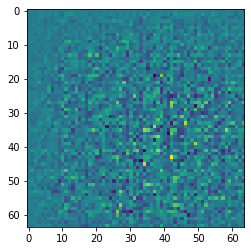

In [9]:
generator = make_generator_model()

noise = tf.random.normal([1, 100])#giving random input vector
generated_image = generator(noise, training=False)

plt.imshow(generated_image[0, :, :, 0] )#printing the generated image by the generator from the rando vector

In [10]:
def make_discriminator_model():
    model = tf.keras.Sequential()
    model.add(tf.keras.layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same',input_shape=[64,64,3]))
    model.add(tf.keras.layers.LeakyReLU())
    model.add(tf.keras.layers.Dropout(0.3))
      
    model.add(tf.keras.layers.Conv2D(256, (5, 5), strides=(2, 2), padding='same'))
    model.add(tf.keras.layers.LeakyReLU())
    model.add(tf.keras.layers.Dropout(0.3))
       
    model.add(tf.keras.layers.Flatten())
    model.add(tf.keras.layers.Dense(1))
    model.summary()

     
    return model


In [ ]:
discriminator = make_discriminator_model()
decision = discriminator(generated_image) #giving the generated image to discriminator,the discriminator will give negative value if it is fake,while if it is real then it will give positive value.
print (decision)

In [12]:
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)#creating loss function

In [13]:
def generator_loss(generated_output):
    return cross_entropy(tf.ones_like(generated_output),generated_output)

In [14]:
def discriminator_loss(real_output, generated_output):
    # [1,1,...,1] with real output since it is true and we want our generated examples to look like it
    real_loss = cross_entropy(tf.ones_like(real_output),real_output)

    # [0,0,...,0] with generated images since they are fake
    generated_loss = cross_entropy(tf.zeros_like(generated_output),generated_output)

    total_loss = real_loss + generated_loss

    return total_loss

In [15]:
generator_optimizer = tf.optimizers.Adam(1e-4)
discriminator_optimizer = tf.optimizers.Adam(1e-4)

In [31]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [32]:
# checkpoint_dir = './training_checkpoints'
checkpoint_dir = '/content/drive/My Drive/GAN3/Checkpoint'
                  #/content/drive/My Drive/GAN3/Checkpoint
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)

In [33]:
EPOCHS = 500
noise_dim = 100
num_examples_to_generate = 1
seed = tf.random.normal([num_examples_to_generate, noise_dim])


In [34]:
def train_step(images):
    noise = tf.random.normal([BATCH_SIZE, noise_dim])

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
      generated_images = generator(noise, training=True)


      real_output = discriminator(images, training=True)
      fake_output = discriminator(generated_images, training=True)

      gen_loss = generator_loss(fake_output)
      disc_loss = discriminator_loss(real_output, fake_output)

    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

In [35]:
def train(dataset, epochs):
  for epoch in range(epochs):
    start = time.time()

    for image_batch in dataset:
      #plt.imshow(image_batch)

      train_step(image_batch)

    generate_and_save_images(generator,epoch + 1,seed)


    if (epoch + 1) % 100 == 0:
      checkpoint.save(file_prefix = checkpoint_prefix)
  
    print ('Time for epoch {} is {} sec'.format(epoch + 1, time.time()-start))

    # Generate after the final epoch
  
  
  generate_and_save_images(generator,
                           epochs,
                           seed)

In [36]:
cd '/content/drive/My Drive/GAN3'

/content/drive/My Drive/GAN3


In [37]:
take_input = input('Is it the first time you are running the model (y/n) : ')

Is it the first time you are running the model (y/n) : y


In [38]:
if take_input == 'y':
    file = open('runtime_count.txt' , 'w')
    count = 1
    flag = 0
    file.write(str(count))
    file.close()


    def generate_and_save_images(model, epoch, test_input):
        # Notice `training` is set to False.
        # This is so all layers run in inference mode (batchnorm).
        predictions = model(test_input, training=False)

        fig = plt.figure(figsize=(4,4))

        for i in range(predictions.shape[0]):
            # plt.subplot(4, 4, i+1)
            plt.imshow(predictions[i, :, :, 0] * 127.5 + 127.5, cmap='gray')
            plt.axis('off')
        file = open('epoch_count.txt' , 'w')
        file.write(str(epoch))
        file.close()
        plt.savefig('{}_image_at_epoch_{:01d}.png'.format(count , epoch))
        plt.show()
else:
    #run this code only if there is a runtime disconnection
    checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))
    flag = 1

In [39]:
if flag == 1:
    file = open('runtime_count.txt', 'r')
    doc = file.read()
    file.close()

    file_1 = open('epoch_count.txt', 'r')
    doc_1 = file_1.read()
    file_1.close()

    count_new = int(doc) + 1
    def generate_and_save_images(model, epoch, test_input):
        # Notice `training` is set to False.
        # This is so all layers run in inference mode (batchnorm).
        predictions = model(test_input, training=False)

        fig = plt.figure(figsize=(4,4))

        for i in range(predictions.shape[0]):
            # plt.subplot(4, 4, i+1)
            plt.imshow(predictions[i, :, :, 0] * 127.5 + 127.5)
            plt.axis('off')
        epoch = epoch + int(doc_1)
        file = open('epoch_count.txt' , 'w')
        file.write(str(epoch))
        file.close()
        plt.savefig('{}_image_at_epoch_{:01d}.png'.format(count_new , epoch))
        plt.show()

    file = open('runtime_count.txt' , 'w')
    file.write(str(count_new))
    file.close()
else:
    print('the code is running for the first time')

the code is running for the first time


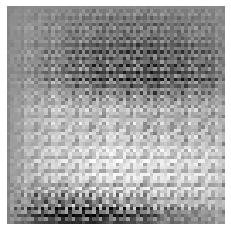

Time for epoch 1 is 111.68479704856873 sec


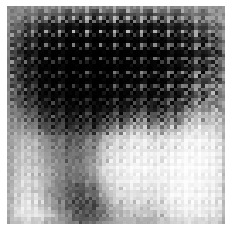

Time for epoch 2 is 110.29479050636292 sec


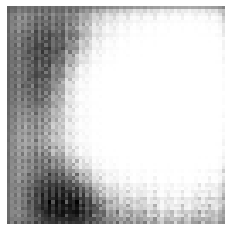

Time for epoch 3 is 109.74194312095642 sec


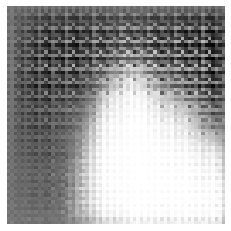

Time for epoch 4 is 109.67149615287781 sec


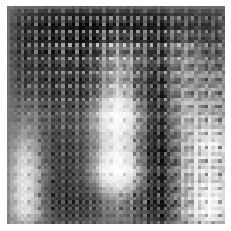

Time for epoch 5 is 109.73628163337708 sec


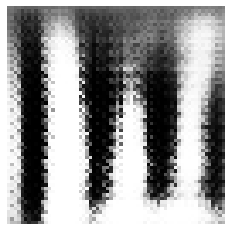

Time for epoch 6 is 109.6564838886261 sec


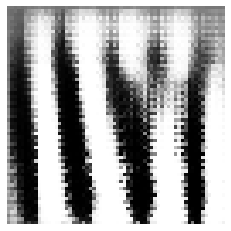

Time for epoch 7 is 109.76640057563782 sec


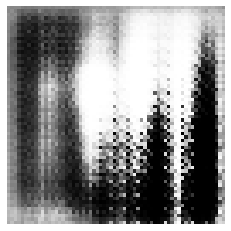

Time for epoch 8 is 109.78580522537231 sec


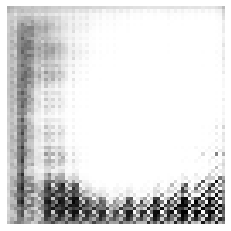

Time for epoch 9 is 109.68348050117493 sec


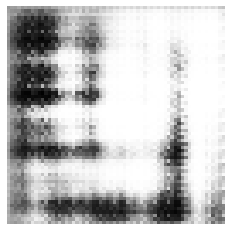

Time for epoch 10 is 109.6121289730072 sec


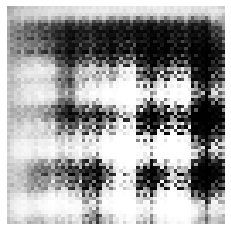

Time for epoch 11 is 109.77480220794678 sec


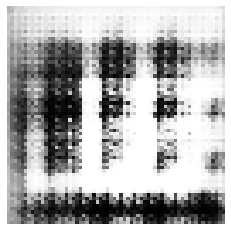

Time for epoch 12 is 109.77790784835815 sec


KeyboardInterrupt: ignored

In [40]:
train(train_dataset, EPOCHS)